In [1]:
from utils.preprocessing import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import joblib
from tensorflow.keras.layers import Dense, Input, Lambda, Dot
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

2025-04-24 14:18:46.096596: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-24 14:18:46.106225: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745500726.116748   42202 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745500726.119838   42202 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-24 14:18:46.131096: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
movie, metadata = preprocessing("utils/Netflix_Movies_and_TV_Shows.csv")
user = create_synthetic_users(movie)
target = create_synthetic_ratings(movie)
print(movie.shape)
print(user.shape)
print(target.shape)

Data before preprocessing
     Title     Type     Genre  Release Year Rating   Duration        Country
0  Title 1  TV Show    Comedy          1955     PG  3 Seasons          Japan
1  Title 2  TV Show    Horror          2020      G  3 Seasons          India
2  Title 3  TV Show    Action          1966  TV-PG    140 min  United States
3  Title 4    Movie  Thriller          2011  PG-13  3 Seasons         Canada
4  Title 5  TV Show   Romance          1959  TV-14    172 min          India
Data after preprocessing
   Type  Genre_Action  Genre_Comedy  Genre_Documentary  Genre_Drama  \
0     0             0             1                  0            0   
1     0             0             0                  0            0   
2     0             1             0                  0            0   
3     1             0             0                  0            0   
4     0             0             0                  0            0   

   Genre_Horror  Genre_Romance  Genre_Sci-Fi  Genre_Thriller

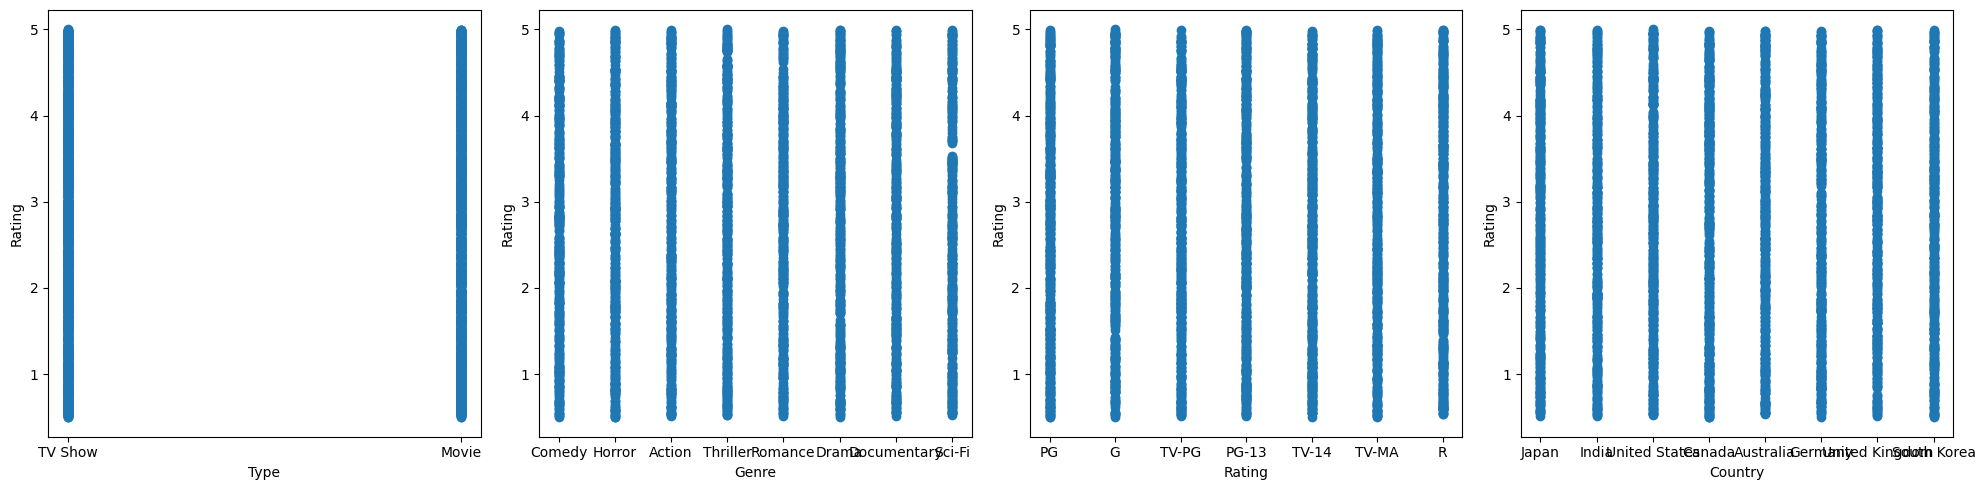

In [4]:
# viewing the relation between feature and synthetic target
visuals = pd.read_csv("utils/Netflix_Movies_and_TV_Shows.csv")
x = visuals["Type"]
x1 = visuals["Genre"]
x2 = visuals["Rating"]
x3 = visuals["Country"]
y = target

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].scatter(x, y)
ax[0].set_xlabel("Type")
ax[0].set_ylabel("Rating")

ax[1].scatter(x1, y)
ax[1].set_xlabel("Genre")
ax[1].set_ylabel("Rating")

ax[2].scatter(x2, y)
ax[2].set_xlabel("Rating")
ax[2].set_ylabel("Rating")

ax[3].scatter(x3, y)
ax[3].set_xlabel("Country")
ax[3].set_ylabel("Rating")


plt.tight_layout()
plt.show()

The synthetic target values are evenly distributed across all groups, indicating no bias towards any particular group

In [5]:
# splitting the dataset into test and train
item_vec = movie.to_numpy()
y_scaler = MinMaxScaler((-1, 1))
y_scaler.fit(target.reshape(-1, 1))
target = y_scaler.transform(target.reshape(-1, 1))

joblib.dump(y_scaler, 'y_scaler.joblib')

item_vec_train, item_vec_test = train_test_split(item_vec, test_size=0.2, random_state=42)
user_vec_train, user_vec_test = train_test_split(user, test_size=0.2, random_state=42)
y_train, y_test = train_test_split(target, test_size=0.2, random_state=42)

print(user_vec_train[:3])
print(item_vec_train[:3])
print(y_train[:3])


[[1 0 1 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0]
 [0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 1 0 1 1 0 0 1 0 1]
 [1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0]]
[[0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0]]
[[-0.57700291]
 [ 0.0654688 ]
 [ 0.94657006]]


In [6]:
# building a neural network
num_output = 25
user_vec = Sequential(
    [
        Dense(100, activation='linear'),
        Dense(50, activation='linear'),
        Dense(num_output, activation='linear')
     ]
)
item_vec = Sequential(
    [
        Dense(100, activation='linear'),
        Dense(50, activation='linear'),
        Dense(num_output, activation='linear')
    ]
)

user_input = Input(shape=(24,))
uv = user_vec(user_input)
uv = Lambda(lambda x: tf.linalg.l2_normalize(x, axis=1))(uv)

item_input = Input(shape=(24,))
iv = item_vec(item_input)
iv = Lambda(lambda x: tf.linalg.l2_normalize(x, axis=1))(iv)

output = Dot(axes=1)([uv, iv])
model = Model([user_input, item_input], output)
model.summary()

2025-04-24 14:19:52.295721: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 25)        │      8,825 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 25)        │      8,825 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 25)        │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 25)        │          0 │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ lambda[0][0],     │
│                     │                   │            │ lambda_1[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,650 (68.95 KB)

 Trainable params: 17,650 (68.95 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Training the model
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.001))
model.fit([user_vec_train, item_vec_train], y_train, epochs=50)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3513 
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3288 
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3032 
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3034 
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3000 
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3040 
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2925 
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2767 
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2834 
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2922 
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2753 
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2690 
Epoch 13/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2718 
Epoch 14/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2668  
Epoch 15/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2696 
Epo

In [8]:
# Evaluating the model performance
model.evaluate([user_vec_test, item_vec_test], y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3782  


0.37804993987083435

In [9]:
model.save("model.keras")